In [3]:
# imports
import os
import sys
sys.path.insert(0, os.path.abspath(r'D:\Code Repos\prey_capture'))
import functions_bondjango as bd
import paths
import os
from caiman.base.rois import register_multisession

import h5py
import numpy as np
import functions_misc as fm
import processing_parameters
import sys
import re
import json
import functions_plotting as fplot
import processing_parameters

C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\tensorf

In [4]:
# load the data

# define the target files
# get the search string
animal = processing_parameters.animal
rig = processing_parameters.rig
search_string = 'slug:%s, analysis_type:calciumday' % (fm.slugify(animal))
# query the database for data to plot
data_all = bd.query_database('analyzed_data', search_string)
# get the paths to the files
calcium_path = [el['analysis_path'] for el in data_all]
# # for testing, filter calcium path
calcium_path = [el for el in calcium_path if ('03_24' in el) or ('03_23' in el) or ('03_29' in el)]

# load the data for the matching
footprint_list = []
size_list = []
template_list = []
# # also store the frame lists
# frame_lists = []
# also store the date for each file
date_list = []
# load the calcium data
for files in calcium_path:
    with h5py.File(files, mode='r') as f:
        try:
            calcium_data = np.array(f['A'])
        except KeyError:
            continue

        # if there are no ROIs, skip
        if (type(calcium_data) == np.ndarray) and (calcium_data == 'no_ROIs'):
            continue
        footprint_list.append(np.moveaxis(calcium_data, 0, -1).reshape((-1, calcium_data.shape[0])))
        size_list.append(calcium_data.shape[1:])
        template_list.append(np.zeros(size_list[0]))
        # template_list.append(np.array(f['max_proj']))
        date_list.append(os.path.basename(files)[:10])
        # frame_lists.append(np.array(f['frame_list']))
print(f'Number of days selected: {len(footprint_list)}')

3


In [5]:
# run cell matching

# run the matching software
spatial_union, assignments, matchings = register_multisession(
    A=footprint_list, dims=size_list[0], templates=template_list, thresh_cost=1.1)

C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\caiman\base\rois.py:438: RuntimeWarning: invalid value encountered in true_divide
  template1 /= template1.max()
C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\caiman\base\rois.py:440: RuntimeWarning: invalid value encountered in true_divide
  template2 /= template2.max()
C:\Users\drguggiana\.conda\envs\caiman\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[[ 0.  0.  1.]
 [ 1.  1.  0.]
 [ 2.  2.  2.]
 [ 3.  3.  4.]
 [ 4.  4.  3.]
 [ 5. 11.  9.]
 [ 6. 13. 10.]
 [ 7. 17. 13.]
 [ 8. 16. 12.]
 [ 9. 19. 16.]
 [10. 23.  5.]
 [11.  5. 14.]
 [12.  6.  7.]
 [13. 26. 20.]
 [14. 28. 21.]
 [15. 29. 17.]
 [16. 31. 22.]
 [17. 30. 23.]
 [18. 34. 25.]
 [19. 36. 19.]
 [20.  7. 26.]
 [21. 38. 27.]
 [22. 40. 28.]
 [23.  8.  6.]
 [24.  9.  8.]
 [25. 41. 32.]
 [26. 43. 30.]
 [27. 44. 34.]
 [28. 45. 39.]
 [29. 46. 40.]
 [30. 51. 33.]
 [31. 54. 43.]
 [32. 10. 36.]
 [33. 12. 11.]
 [34. 14. 37.]
 [35. 56. 45.]
 [36. 15. 31.]
 [37. 58. 53.]
 [38. 63. 44.]
 [39. 18. 15.]
 [40. 65. 60.]
 [41. 69. 47.]
 [42. 20. 48.]
 [43. 21. 49.]
 [44. 84. 50.]
 [45. 81. 52.]
 [46. 22. 35.]
 [nan 24. 55.]
 [nan 25. 18.]
 [nan 27. 57.]
 [nan 32. 58.]
 [nan 33. 24.]
 [nan 35. 59.]
 [nan 37. 29.]
 [nan 39. 61.]
 [nan 42. 63.]
 [nan 47. 41.]
 [nan 48. 38.]
 [nan 49. 65.]
 [nan 50. 42.]
 [nan 52. 67.]
 [nan 53. 70.]
 [nan 55. 46.]
 [nan 57. 51.]
 [nan 59. 54.]
 [nan 60. 72.]
 [nan 61. 

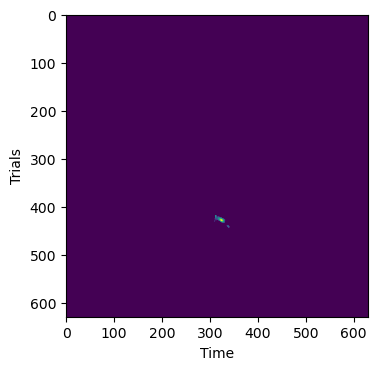

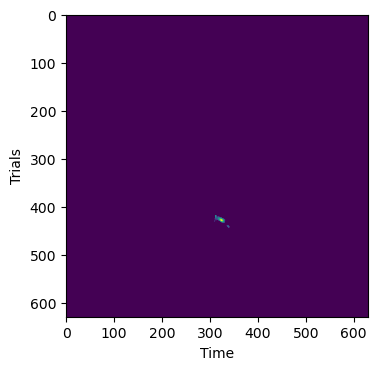

In [22]:
# visualize cell matching

#print(footprint_list[0].shape)
#print(size_list[0])
print(assignments)
#print(matchings)
target_image = spatial_union[:, 41].reshape((630, 630))
fplot.plot_image([target_image])

# generate the colors for all the cells


# for all the units
# for all the trials
for trial in footprint_list:
    